In [1]:
#coding:UTF-8
import os
import sys
import numpy as np
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import seaborn as sns
from scipy import sparse
import shutil
from tqdm.notebook import tqdm

import anndata
import scanpy as sc
from scipy import sparse

sc.logging.print_header()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.9.1 leidenalg==0.8.3


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# BGI DATA

## 装箱数据集

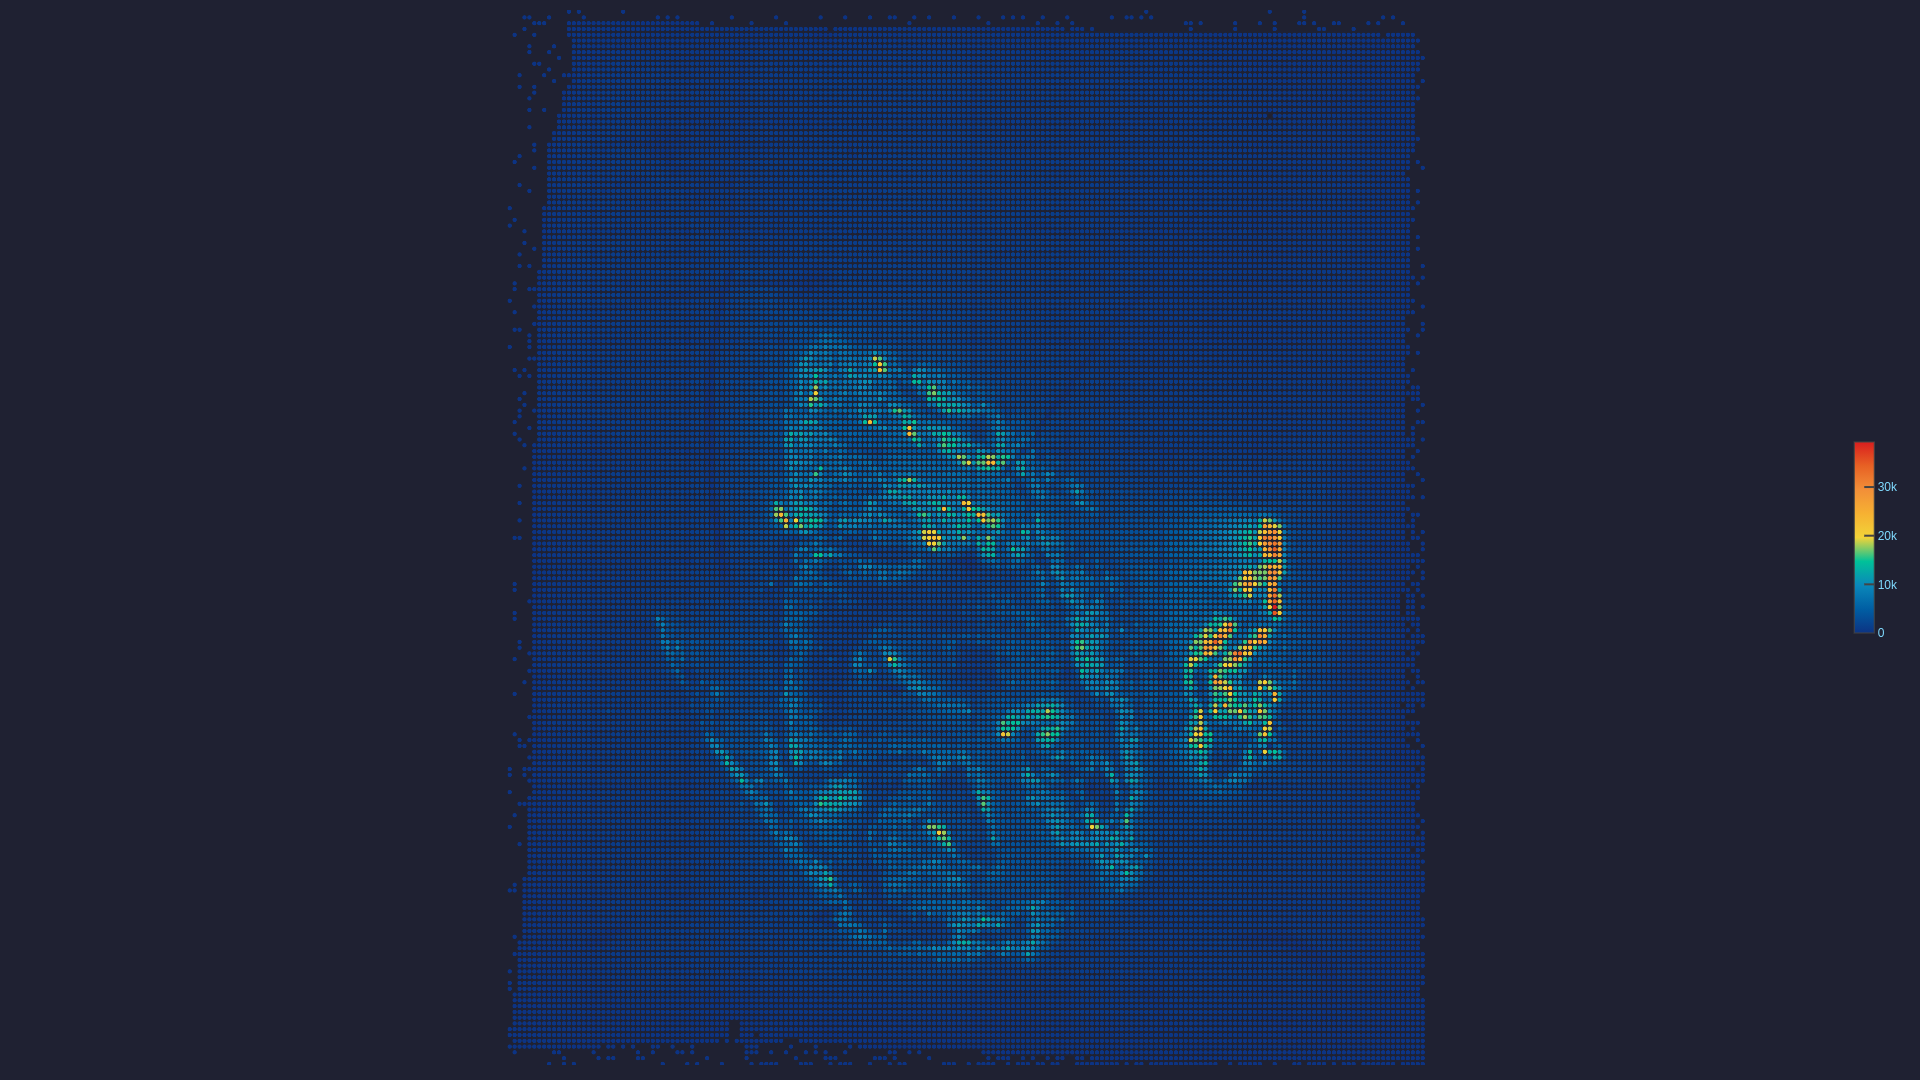

In [3]:
# 打印图像
# root_file = '/media/bgi/zhannianji/workdir/smart/single-cell/spatial/data/'


root_dir = '/hwfssz1/BIGDATA_COMPUTING/heshixu/stereo_RNA/data'
data_fname = '90B6/00.data/DP8400015290BL_B6.merge_GetExp_gene.txt' 
im_data_fname = '90B6/90B6_HE.png'

ori_data_fname = os.path.join(root_dir, data_fname)
ori_im_fname = os.path.join(root_dir, im_data_fname)

im = Image.open(ori_im_fname)

im
# from PIL import Image
# im = Image.open(root_file+'bgi_data/heshixu_stereo_RNA/90B6/90B6_HE.png')
# im

In [4]:
# 读取源文件(genes,x,y,UMIcounts)
ori_data_df = pd.read_csv(ori_data_fname,delimiter='\t')
ori_data_df.head()

,geneID,x,y,UMICount
0,PGBD2,7260,5546,1
1,PGBD2,12100,9251,1
2,PGBD2,6605,8109,1
3,PGBD2,9643,8864,1
4,PGBD2,12908,6932,1


In [5]:
ori_data_df.isnull().sum()

geneID      0
x           0
y           0
UMICount    0
dtype: int64

In [6]:
# 下采样大小
bin_s=100

# 确定是否保存为npz，默认保存为稀疏矩阵的形式
save_confirm=True
save_txt = '/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/stCluster/results/90b6_bin100.npz'

# main
# df.dropna(inplace=True)
# df.columns = list(df.columns[0:-1]) + ['UMICount']
ori_data_df['x1'] = (ori_data_df['x'] // bin_s).astype(np.int32)
ori_data_df['y1'] = (ori_data_df['y'] // bin_s).astype(np.int32)
ori_data_df['pos'] = ori_data_df['x1'].astype(str) + "-" + ori_data_df['y1'].astype(str)

ori_data_df.head()


,geneID,x,y,UMICount,x1,y1,pos
0,PGBD2,7260,5546,1,72,55,72-55
1,PGBD2,12100,9251,1,121,92,121-92
2,PGBD2,6605,8109,1,66,81,66-81
3,PGBD2,9643,8864,1,96,88,96-88
4,PGBD2,12908,6932,1,129,69,129-69


In [7]:
# 将下采样后相同坐标的相同基因求和，得到新的坐标点对应的基因列表和新的计数矩阵
bindf = ori_data_df.groupby(['pos', 'geneID'])['UMICount'].sum()

In [8]:
bindf.head()

pos      geneID 
100-100  A2M        1
         A2M-AS1    2
         A4GALT     1
         AAAS       1
         AACS       1
Name: UMICount, dtype: int64

In [9]:
p_table = pd.pivot_table(ori_data_df, values='UMICount', index=['pos'], columns=['geneID'], aggfunc=np.sum, fill_value=0)

# get columns: p_table.columns
# get rows: p_table.index
# get values: p_table.values

In [10]:
p_table

geneID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,A3GALT2,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
pos,,,,,,,,,,,,,,,,,,,,,
100-100,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
100-101,0,0,0,3,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-102,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-103,0,0,0,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-104,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-95,0,0,0,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
99-96,2,0,0,2,6,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99-97,0,0,0,4,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# cells = list(set(x[0] for x in bindf.index))
# genes = list(set(x[1] for x in bindf.index))
# cellsdic = dict(zip(cells, range(0, len(cells))))
# genesdic = dict(zip(genes, range(0, len(genes))))

# # 统计下采样后的bin大小和基因数
# rows = [cellsdic[x[0]] for x in bindf.index]
# cols = [genesdic[x[1]] for x in bindf.index]
# print(f'the martrix has {len(cells)} bins, and {len(genes)} genes.')

# # 保存为稀疏矩阵形式，节约空间
# expMtx = sparse.csr_matrix((bindf.values, (rows, cols)))
# # print(f'the size of matrix is {sys.getsizeof(expMtx.toarray().transpose()) / 1073741824} G.')

# # 保存为文件
# if save_confirm:
#     np.savez_compressed(file=save_txt,data=expMtx,index=cells,columns=genes)
# print('保存完成！')

#   geneID      x     y  UMICount   x1  y1     pos
# 0  PGBD2   7260  5546         1   72  55   72-55
# 1  PGBD2  12100  9251         1  121  92  121-92
# 2  PGBD2   6605  8109         1   66  81   66-81
# 3  PGBD2   9643  8864         1   96  88   96-88
# 4  PGBD2  12908  6932         1  129  69  129-69
# the martrix has 20692 bins, and 41639 genes.
# 保存完成！

In [12]:
# bin函数
# def read_raw_file(inpath, step, split=1, outpath="bin.tsv"):
#     df = pd.read_csv(inpath, sep='\t')
#     df.dropna(inplace=True)
#     df.columns = list(df.columns[0:-1]) + ['UMICount']
#     df['x1'] = (df['x'] / step).astype(np.int32)
#     df['y1'] = (df['y'] / step).astype(np.int32)
#     df['pos'] = df['x1'].astype(str) + "-" + df['y1'].astype(str)
#     bindf = df.groupby(['pos', 'geneID'])['UMICount'].sum()
#     cells = set(x[0] for x in bindf.index)
#     genes = set(x[1] for x in bindf.index)
#     cellsdic = dict(zip(cells, range(0, len(cells))))
#     genesdic = dict(zip(genes, range(0, len(genes))))
#     rows = [cellsdic[x[0]] for x in bindf.index]
#     cols = [genesdic[x[1]] for x in bindf.index]
#     print(f'the martrix has {len(cells)} bins, and {len(genes)} genes.')
#     expMtx = sparse.csr_matrix((bindf.values, (rows, cols))).toarray().transpose()
#     print(f'the size of matrix is {sys.getsizeof(expMtx) / 1073741824}G.')
#     pd.DataFrame(data=expMtx, index = genes, columns = cells).to_csv(outpath, sep="\t")

## 载入数据

In [13]:
#读取稀疏矩阵的方式，存入anndata结构
# data = np.load('./analysis_01/90b6_bin100.npz',allow_pickle=True)
adata = sc.AnnData(X=p_table.values,
                   obs=pd.DataFrame(index = p_table.index.tolist()),
                   var=pd.DataFrame(index = p_table.columns.tolist()))

# 读取文本矩阵的方式，存入anndata结构
# adata = sc.read_csv(filename='./analysis_01/90b6_bin100.txt',delimiter='\t')

# 计算线粒体
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# 计算count
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

print(adata)

AnnData object with n_obs × n_vars = 20692 × 41639
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


## 过滤和质控

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

<AxesSubplot:xlabel='n_genes_by_counts'>

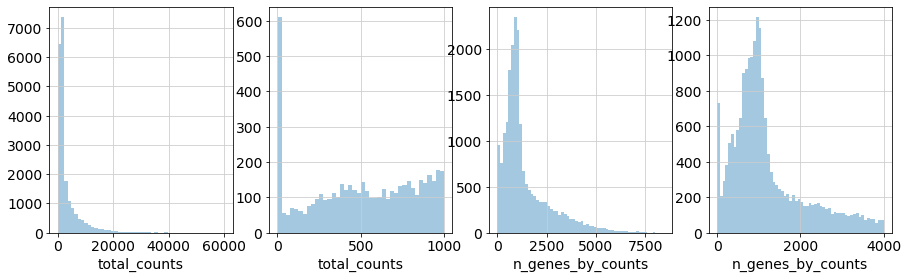

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 1000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [15]:
# 参考bin50大部分用的参数都是这几个
# filter_cells(min_genes=200)
# filter_genes(min_cell=3)
# adata[adata.obs.n_genes_by_counts < 7000, :] （数据量大的话不设上限）
# adata[adata.obs.pct_counts_mt < 15, :]


print('原始数据读取：',adata)
adata.var_names_make_unique()

# filter_0
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_cells(adata, max_counts=35000)
# adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)


# filter_1
# sc.pp.filter_cells(adata, min_genes=200)
# # sc.pp.filter_cells(adata, max_counts=3)
# sc.pp.filter_genes(adata, min_cells=3)
# adata = adata[adata.obs["pct_counts_mt"] < 20]
# print(f"#cells after MT filter: {adata.n_obs}")
print('过滤后:',adata)

原始数据读取： AnnData object with n_obs × n_vars = 20692 × 41639
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
filtered out 12529 cells that have less than 2000 counts


/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 48 cells that have more than 35000 counts
#cells after MT filter: 8115
filtered out 13818 genes that are detected in less than 10 cells
过滤后: AnnData object with n_obs × n_vars = 8115 × 27821
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'


In [16]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
print('过滤后：',adata)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
过滤后： AnnData object with n_obs × n_vars = 8115 × 27821
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [17]:
# adata.to_df().to_csv('./analysis_01/90b6_bin20_filter.csv')

In [18]:
sc.pp.pca(adata,n_comps=15)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

computing PCA
    on highly variable genes
    with n_comps=15


/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15


/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)
running Leiden clustering
    finished: found 14 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:01)


In [19]:
adata

AnnData object with n_obs × n_vars = 8115 × 27821
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'clusters'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [20]:
# pd.DataFrame(data=adata.obsm['X_pca'],index=adata.obs_names).to_csv('./analysis_01/test.csv',header=None)

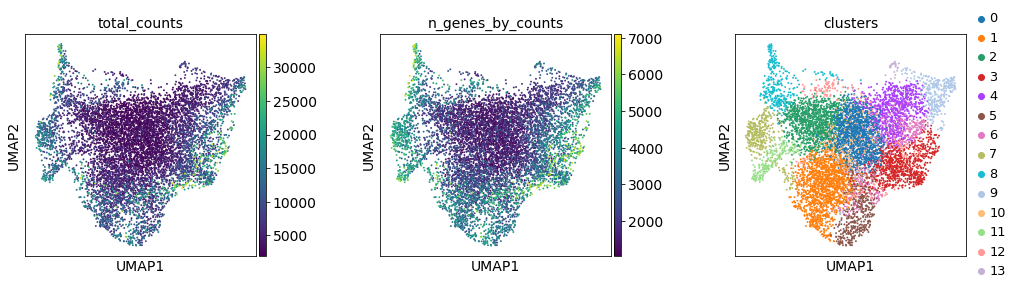

In [21]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

In [22]:
# PCA data 

adata.obsm['X_pca'].shape

(8115, 15)

In [46]:
adata.uns['hvg']

{'flavor': 'seurat'}

In [23]:
adata.obs_names

Index(['100-100', '100-101', '100-102', '100-103', '100-104', '100-105',
       '100-106', '100-107', '100-108', '100-109',
       ...
       '99-90', '99-91', '99-92', '99-93', '99-94', '99-95', '99-96', '99-97',
       '99-98', '99-99'],
      dtype='object', length=8115)

In [24]:
adata.obsm['X_pca']

array([[ 4.0840898 ,  2.0111475 , -0.11765787, ...,  0.60019577,
        -0.09254171, -0.2899737 ],
       [ 1.8610502 ,  0.4836598 , -0.24341945, ...,  0.07136425,
        -0.65123534,  0.1351458 ],
       [ 3.3650782 ,  0.6068314 , -0.85083956, ...,  0.75918496,
         0.3195911 ,  0.5253382 ],
       ...,
       [-1.2423974 ,  0.5248753 ,  0.83539265, ..., -0.37421745,
        -0.8479687 , -0.20651576],
       [ 0.7539778 ,  0.98178923,  0.1724529 , ..., -0.06285474,
        -0.47585708,  0.5857235 ],
       [ 1.6350986 ,  1.5493348 ,  1.0468646 , ...,  0.4089569 ,
         0.09649929,  0.36649632]], dtype=float32)

In [25]:
from sklearn.preprocessing import MinMaxScaler

adata.obsm['X_pca'] = MinMaxScaler(feature_range=(0.1,1)).fit_transform(adata.obsm['X_pca'])

In [26]:
adata.obs_names

Index(['100-100', '100-101', '100-102', '100-103', '100-104', '100-105',
       '100-106', '100-107', '100-108', '100-109',
       ...
       '99-90', '99-91', '99-92', '99-93', '99-94', '99-95', '99-96', '99-97',
       '99-98', '99-99'],
      dtype='object', length=8115)

In [27]:
#读取pca数据

xs = [int(i.split('-')[0]) for i in adata.obs_names.tolist()]
ys = [int(i.split('-')[1]) for i in adata.obs_names.tolist()]

mxt = np.zeros((15, max(xs)+1, max(ys)+1))

index_lst = adata.obs_names.tolist()

for i,idx in enumerate(index_lst):
     mxt[:, int(idx.split('-')[0]), int(idx.split('-')[1])] = adata.obsm['X_pca'][i,:]


In [28]:
mxt.shape

(15, 153, 148)

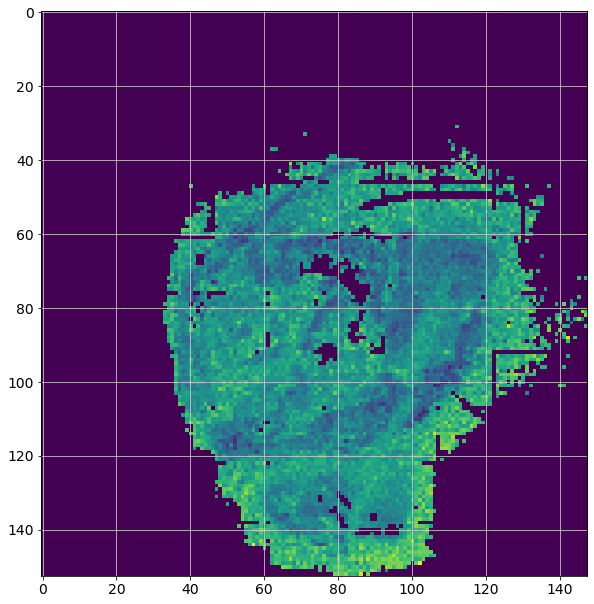

In [29]:
plt.figure(figsize=[10,10])
plt.imshow(mxt[3])

## unsupervised-segmentation

In [30]:
#coding:UTF-8
import os
import sys
import numpy as np
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from scipy import sparse
import shutil
from tqdm.notebook import tqdm

#from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init

use_cuda = torch.cuda.is_available()

# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim,nChannel,nConv):
        super(MyNet, self).__init__()
        self.nConv = nConv
        self.conv1 = nn.Conv2d(input_dim, nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(nConv-1):
            self.conv2.append( nn.Conv2d(nChannel, nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(nChannel) )
        self.conv3 = nn.Conv2d(nChannel, nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(self.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x
print('\n模型放入GPU')
CUDA=torch.cuda.is_available()
device_ids = [0]
# nnet = MyNet(data.size(1),100,2)
# nnet(data.cpu())


模型放入GPU


In [31]:
torch.__version__

'1.7.1+cu101'

In [32]:

torch.version.cuda

'10.1'

In [33]:
#读取pca数据
#通过坐标填值
pca=15
#转成模型输入torch格式
data = torch.from_numpy(mxt.astype('float32'))
data = data.cuda(device_ids[0])
data = torch.unsqueeze(data,0)
data.shape

torch.Size([1, 15, 153, 148])

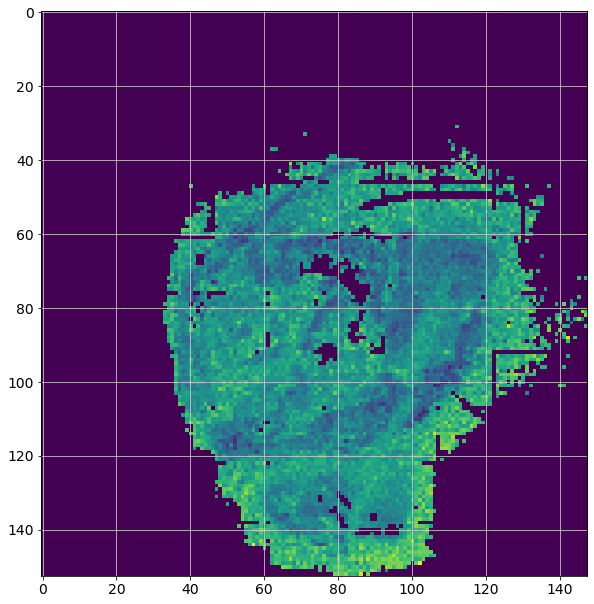

In [34]:
plt.figure(figsize=[10,10])
plt.imshow(mxt[3])

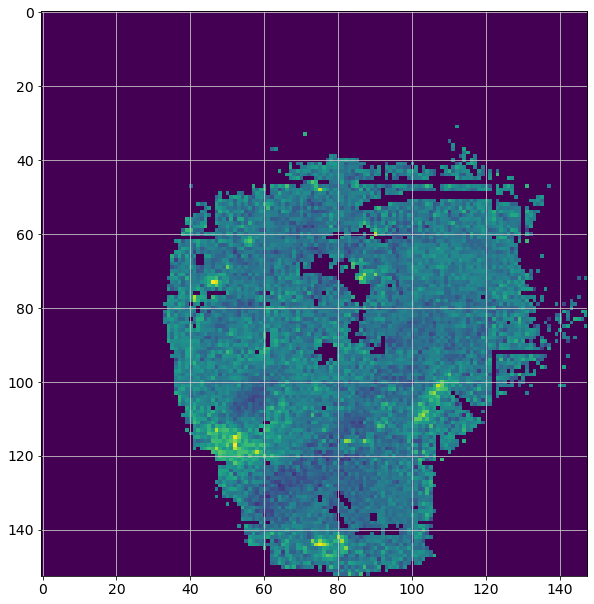

In [35]:
plt.figure(figsize=[10,10])
plt.imshow(mxt[6])

In [36]:
# # load image
# input = './analysis_01/pytorch-unsupervised-segmentation/images/101027.jpg'
# im = cv2.imread(input)
# print(im.shape)
# data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )

# data = data.cuda(device_ids[0])
# data = Variable(data)
# print(data.shape)
# plt.imshow(im)
# print(im.shape)

DataParallel(
  (module): MyNet(
    (conv1): Conv2d(15, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn2): ModuleList(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  # Remove the CWD from sys.path while we load stuff.


0 / 400 : 63 3.6981143951416016
1 / 400 : 62 3.4900784492492676
2 / 400 : 56 3.2169668674468994
3 / 400 : 54 3.002040386199951
4 / 400 : 51 2.755031108856201
5 / 400 : 47 2.5172553062438965
6 / 400 : 44 2.161130666732788
7 / 400 : 38 1.9024981260299683
8 / 400 : 26 1.6265567541122437
9 / 400 : 24 1.417938470840454
10 / 400 : 16 1.2448086738586426
11 / 400 : 15 1.0971254110336304
12 / 400 : 12 0.9754275679588318
13 / 400 : 9 0.8170526623725891
14 / 400 : 10 0.743310809135437
15 / 400 : 10 0.7158133387565613
16 / 400 : 7 0.5965873003005981
17 / 400 : 7 0.5532227754592896
18 / 400 : 7 0.4954317510128021
19 / 400 : 7 0.4329156279563904
20 / 400 : 7 0.40501144528388977
21 / 400 : 7 0.3758363127708435
22 / 400 : 7 0.3485322892665863
23 / 400 : 7 0.32409578561782837
24 / 400 : 7 0.3048204481601715
25 / 400 : 7 0.2924169600009918
26 / 400 : 7 0.28169339895248413
27 / 400 : 7 0.2713537812232971
28 / 400 : 7 0.25839218497276306
29 / 400 : 7 0.24958960711956024
30 / 400 : 7 0.2444881796836853
31 

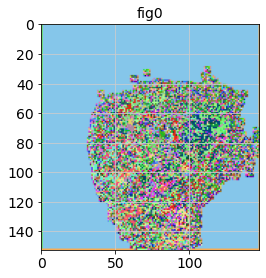

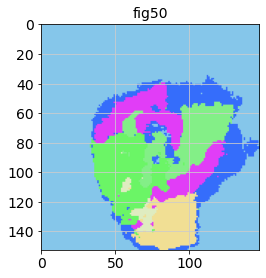

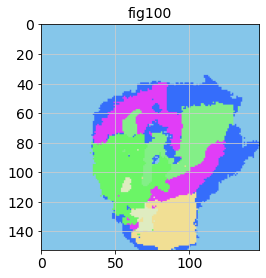

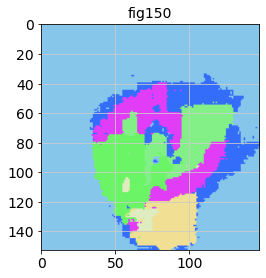

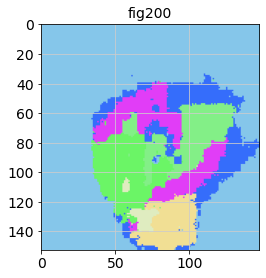

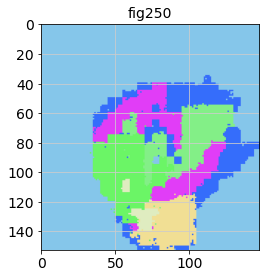

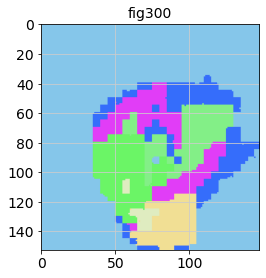

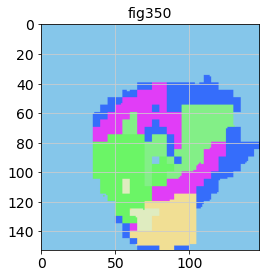

In [44]:
nChannel=64
nConv=2
net=MyNet(input_dim=data.size(1),nChannel=nChannel,nConv=nConv)
model = nn.DataParallel(net,device_ids=device_ids)
model = model.cuda(device=device_ids[0])  # 模型放在主设备
print(model)

# slic
im = np.transpose(mxt,[1,2,0])
labels = segmentation.slic(im, compactness=100, n_segments=1000)
labels = labels.reshape(im.shape[0]*im.shape[1])
u_labels = np.unique(labels)
l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

# train

maxIter = 400
minLabels = 2

# model = MyNet( data.size(1) )
# if use_cuda:
#     model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))

visualize = 1
for batch_idx in range(maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
#     if visualize:
    if batch_idx%50==0:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im[:,:,:3].shape ).astype( np.uint8 )
        plt.figure()
        plt.title('fig{}'.format(batch_idx))
        plt.imshow(im_target_rgb)
#         cv2.imshow( "output", im_target_rgb )
#         cv2.waitKey(10)

    # superpixel refinement
    # TODO: use Torch Variable instead of numpy for faster calculation
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    target = target.cuda(device_ids[0])
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    #print (batch_idx, '/', args.maxIter, ':', nLabels, loss.data[0])
    print (batch_idx, '/', maxIter, ':', nLabels, loss.item())

    if nLabels <= minLabels:
        print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
        break

In [ ]:
im_target.max()

In [ ]:
# save output image
if not visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
cv2.imwrite( "output.png", im_target_rgb )

# VISIUM DATA

In [ ]:
adata=sc.read_visium(path='../data/published_data/10x_dataset/download/Parent_Visium_Human_OvarianCancer/',count_file='Parent_Visium_Human_OvarianCancer_raw_feature_bc_matrix.h5',load_images=True,source_image_path='spatial')
adata.var_names_make_unique()

In [ ]:
adata

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires")

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [ ]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

In [ ]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

In [ ]:
sc.pl.spatial(adata, img_key="hires", color="clusters", groups=["0", "5"], crop_coord=[100, 1700, 1900, 1000], alpha=0.5, size=1.3)